# This work is licensed under a Creative Commons BY 4.0 license https://creativecommons.org/licenses/by/4.0/

Copyright (c) 2022-2023, D. Kuiri, M. P. Nowak

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

## Majorana zero modes in 2D SNS junction for open system
### A SNS junction with bottom and top contacts attached. In this system also the supereconducting regions are replaced by leads. This will come in two flavours - with and without tunneling barriers.

In [1]:
import ipyparallel as ipp

cluster = ipp.Client()

v = cluster[:]
lview = cluster.load_balanced_view()
len(v)

40

In [2]:
%%px --local

import os
   
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=1
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=1 
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=1                              #Block multithreading
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=1
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=1

In [3]:
%%px --local

import tinyarray
import kwant
import numpy as np
from matplotlib import pyplot as plt
import warnings
import scipy.constants as sc
import scipy.sparse.linalg as sla
from kwant.digest import uniform

In [4]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from adaptive import notebook_extension, Runner, Learner1D, Learner2D   #for adaptive plot
import adaptive
from ipywidgets import interact
import pickle
from scipy.signal import argrelextrema
import matplotlib.colors as colors

notebook_extension()

## To make the open system

In [5]:
%%px --local

sigma_0 = np.identity(2)
sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.array([[1, 0], [0, -1]])
sigma_1 = np.array([[0, 1], [0, 0]])
sigma_2 = np.array([[0, 0], [1, 0]])
sigma_0sigma_z = np.array(np.kron(sigma_0,sigma_z))
sigma_ysigma_0 = np.array(np.kron(sigma_y,sigma_0))
sigma_xsigma_z = np.array(np.kron(sigma_x,sigma_z))
sigma_ysigma_z = np.array(np.kron(sigma_y,sigma_z))
sigma_0sigma_x = np.array(np.kron(sigma_0,sigma_x))
sigma_0sigma_1 = np.array(np.kron(sigma_0,sigma_1))
sigma_0sigma_2 = np.array(np.kron(sigma_0,sigma_2))

def make_system_open(L_j = 80, W = 2000, W_q = 100, bottom_leads = True, vertical_leads = True):  
    a = 10e-9
    m = sc.m_e*0.014
    m2 = m*10
    t = (sc.hbar**2/(2*m*a**2))/sc.eV
    tm = (sc.hbar**2/(2*m2*a**2))/sc.eV
    g = -50
    miu_B = ((sc.e*sc.hbar)/(2*sc.m_e))/sc.eV
    
    
    
    def barrier_potential_top(x, y, V_g1, L_j = L_j, W_q =W_q, y_position = (W/2 + W_q/5)):
        ret = 0
        if (W/2 < y < y_position  and -L_j/2 <= x <= L_j/2):
            ret = V_g1
    
        return ret
    
    def barrier_potential_bottom(x, y, V_g2, L_j = L_j, W_q =W_q, y_position_n = -(W/2 + W_q/5)):
        ret = 0
        if ( y_position_n < y < -W/2  and -L_j/2 <= x <= L_j/2):
            ret = V_g2

        return ret
    
    def onsite(site, V_g1, V_g2, B,mu):
        (x, y) = site.pos
        return (4*t - mu + barrier_potential_top(x, y, V_g1) + barrier_potential_bottom(x, y, V_g2))*sigma_0sigma_z + \
                (g/2)*miu_B*B*sigma_ysigma_0   
    
    
    
    def hoppingx(site1, site2, alpha):
        (x1,y1 ) = site1.pos
        (x2,y2) = site2.pos
        return -t*sigma_0sigma_z - alpha*(1j/(2*a*1e9))*sigma_ysigma_z   
        
                
    def hoppingy(site1, site2, alpha):
        (x1,y1 ) = site1.pos
        (x2,y2) = site2.pos
        return -t*sigma_0sigma_z  + alpha*(1j/(2*a*1e9))*sigma_xsigma_z
    
 
    def onsite_left_SC_lead(site, Delta,mu):
        (x, y) = site.pos
        return (2*t + 2*tm - mu )*sigma_0sigma_z  + Delta*sigma_0sigma_x 
    
    def onsite_right_SC_lead(site, phi, Delta,mu):         
        (x, y) = site.pos
        return (2*t + 2*tm - mu )*sigma_0sigma_z  +  Delta*np.exp(1j*phi)*sigma_0sigma_1 + \
    Delta*np.exp(-1j*phi)*sigma_0sigma_2
    
    def onsite_normal_lead(site, mu, B):
        (x, y) = site.pos
        return (4*t - mu )*sigma_0sigma_z + (g/2)*miu_B*B*sigma_ysigma_0
    
    def wire_top(pos):
        (x, y) = pos
        return (-L_j /2 <= x <= L_j /2)
        
    def wire_bottom(pos):
        (x, y) = pos
        return (-L_j /2 <= x <= L_j /2 )
    
    
    def wire_left(pos):
        (x, y) = pos
        return (-W /2 <= y <= W /2)

        
    def wire_right(pos):
        (x, y) = pos
        return (-W /2 <= y <= W /2)
        
    def wire(pos):
        (x, y) = pos
        return (-L_j /2 <= x <= L_j /2  and -W/2 - W_q <= y <= W_q + W /2)

    lat = kwant.lattice.square(a*1e9, norbs = 4)
    syst = kwant.Builder()
    
    syst[lat.shape(wire, (0,0))] = onsite
    syst[kwant.builder.HoppingKind((1, 0), lat, lat)] = hoppingx
    syst[kwant.builder.HoppingKind((0, 1), lat, lat)] = hoppingy
    sym_left = kwant.TranslationalSymmetry((-a*1e9, 0 ))
    
    lead0 = kwant.Builder(sym_left)
    lead0[lat.shape(wire_left, (0, 0))] = onsite_left_SC_lead
    lead0[kwant.builder.HoppingKind((1, 0), lat, lat)] = -t * sigma_0sigma_z
    lead0[kwant.builder.HoppingKind((0, 1), lat, lat)] = -tm * sigma_0sigma_z
    sym_right = kwant.TranslationalSymmetry((a*1e9, 0))
    
    lead1 = kwant.Builder(sym_right)
    lead1[lat.shape(wire_right, (0, 0))] = onsite_right_SC_lead
    lead1[kwant.builder.HoppingKind((1, 0), lat, lat)] = -t * sigma_0sigma_z
    lead1[kwant.builder.HoppingKind((0, 1), lat, lat)] = -tm *sigma_0sigma_z
    sym_top = kwant.TranslationalSymmetry((0, a*1e9 ))
    
    lead2 = kwant.Builder(sym_top, conservation_law=-sigma_0sigma_z)
    lead2[lat.shape(wire_top, (0, 0))] = onsite_normal_lead
    lead2[kwant.builder.HoppingKind((1, 0), lat, lat)] = hoppingx
    lead2[kwant.builder.HoppingKind((0, 1), lat, lat)] = hoppingy
    sym_below = kwant.TranslationalSymmetry((0, -a*1e9 ))
    
    lead3 = kwant.Builder(sym_below, conservation_law=-sigma_0sigma_z)
    lead3[lat.shape(wire_bottom, (0, 0))] = onsite_normal_lead 
    lead3[kwant.builder.HoppingKind((1, 0), lat, lat)] = hoppingx
    lead3[kwant.builder.HoppingKind((0, 1), lat, lat)] = hoppingy
    syst.attach_lead(lead2)
    
    if (bottom_leads == True):
        syst.attach_lead(lead3)
        
    if (vertical_leads == True):
        syst.attach_lead(lead0)
        syst.attach_lead(lead1)
    
    return syst        

In [6]:
syst_open = make_system_open(L_j = 80, W = 200, W_q = 100, bottom_leads = True, vertical_leads = True)
sysf_open = syst_open.finalized()

/opt/conda/miniconda3/envs/python3/lib/python3.9/site-packages/kwant/plotter.py:144: ComplexWarning: Casting complex values to real discards the imaginary part
  color = np.asarray(color, dtype=float)


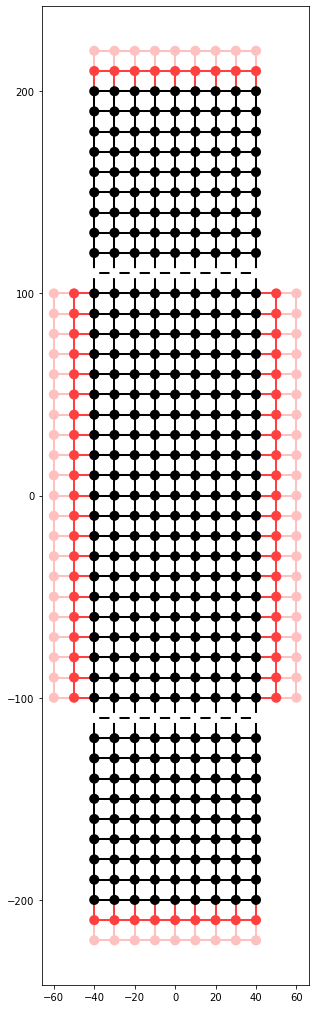

In [7]:
kwant.plotter.plot(sysf_open, fig_size = (18,18), colorbar = False,\
        site_color=lambda site: sysf_open.hamiltonian(site, site, params = dict(B = 2, alpha = 10*1e-3,V_g1 = 10, V_g2 = 10,\
                                                                           mu=4*1e-3, Delta = 0.2*1e-3,phi = 0))[0,0]);

## Non local conductance map w.r.t $E$ and $\phi$ 

### for top leads

In [10]:
%%px --local

def calculate_nonlocal_conductance_map_top_an_diff_pot_height(phienergy, L_j, W, W_q, V_g1, V_g2, mu, alpha, Delta, B):
    phi, energy = phienergy
    
    syst_open = make_system_open(L_j = L_j, W = W, W_q = W_q, bottom_leads = True, vertical_leads = True)
    sysf_open = syst_open.finalized()

    smatrix = kwant.smatrix(sysf_open, energy = energy*1e-3, params =dict( V_g1 = V_g1, V_g2 = V_g2,mu=mu, alpha = alpha, \
                                                                 Delta = Delta, B = B, phi =phi))
    
    return smatrix.transmission((0, 0), (1, 0)) - smatrix.transmission((0, 1), (1, 0))

### for bottom leads

In [11]:
%%px --local

def calculate_nonlocal_conductance_map_bottom_an_diff_pot_height(phienergy, L_j, W, W_q, V_g1, V_g2, mu, alpha, Delta, B):
    phi, energy = phienergy
    
    syst_open = make_system_open(L_j = L_j, W = W, W_q = W_q, bottom_leads = True, vertical_leads = True)
    sysf_open = syst_open.finalized()

    smatrix = kwant.smatrix(sysf_open, energy = energy*1e-3, params =dict( V_g1 = V_g1, V_g2 = V_g2,mu=mu, alpha = alpha, \
                                                                 Delta = Delta, B = B, phi =phi))
    
    return smatrix.transmission((1, 0), (0, 0)) - smatrix.transmission((1, 1), (0, 0))

In [14]:
import matplotlib
def _make_figure(dpi, fig_size):
    fig = plt.figure()

    if dpi is not None:
        fig.set_dpi(dpi)
    if fig_size is not None:
        fig.set_figwidth(fig_size[0])
        fig.set_figheight(fig_size[1])
    return fig

def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return idx


def streamplot_x_cut(field, box, x_min = None, x_max=None, cmap=None, bgcolor=None, linecolor='k',
               max_linewidth=3, min_linewidth=1, density=2/9,
               colorbar=True, file=None,
               show=True, dpi=None, fig_size=None, ax=None,
               vmax=None):
    """Draw streamlines of a flow field in Kwant style, but trimm horizontally

    Solid colored streamlines are drawn, superimposed on a color plot of
    the flow speed that may be disabled by setting `bgcolor`.  The width
    of the streamlines is proportional to the flow speed.  Lines that
    would be thinner than `min_linewidth` are blended in a perceptually
    correct way into the background color in order to create the
    illusion of arbitrarily thin lines.  (This is done because some plot
    backends like PDF do not support lines of arbitrarily thin width.)

    Internally, this routine uses matplotlib's streamplot.

    Parameters
    ----------
    field : 3d arraylike of float
        2d array of 2d vectors.
    box : 2-sequence of 2-sequences of float
        the extents of `field`: ((x0, x1), (y0, y1))
    cmap : colormap, optional
        Colormap for the background color plot.  When not set the colormap
        "kwant_red" is used by default, unless `bgcolor` is set.
    bgcolor : color definition, optional
        The solid color of the background.  Mutually exclusive with `cmap`.
    linecolor : color definition
        Color of the flow lines.
    max_linewidth : float
        Width of lines at maximum flow speed.
    min_linewidth : float
        Minimum width of lines before blending into the background color begins.
    density : float
        Number of flow lines per point of the field.  The default value
        of 2/9 is chosen to show two lines per default width of the
        interpolation bump of `~kwant.plotter.interpolate_current`.
    colorbar : bool
        Whether to show a colorbar if a colormap is used. Ignored if `ax` is
        provided.
    file : string or file object or `None`
        The output file.  If `None`, output will be shown instead.
    show : bool
        Whether ``matplotlib.pyplot.show()`` is to be called, and the output is
        to be shown immediately.  Defaults to `True`.
    dpi : float or `None`
        Number of pixels per inch.  If not set the ``matplotlib`` default is
        used.
    fig_size : tuple or `None`
        Figure size `(width, height)` in inches.  If not set, the default
        ``matplotlib`` value is used.
    ax : ``matplotlib.axes.Axes`` instance or `None`
        If `ax` is not `None`, no new figure is created, but the plot is done
        within the existing Axes `ax`. in this case, `file`, `show`, `dpi`
        and `fig_size` are ignored.
    vmax : float or `None`
        The upper saturation limit for the colormap; flows higher than
        this will saturate.  Note that there is no corresponding vmin
        option, vmin being fixed at zero.

    Returns
    -------
    fig : matplotlib figure
        A figure with the output if `ax` is not set, else None.
    """

    # Matplotlib's "density" is in units of 30 streamlines...
    density *= 1 / 30 * np.array(field.shape[:2], int)

    # Matplotlib plots images like matrices: image[y, x].  We use the opposite
    # convention: image[x, y].  Hence, it is necessary to transpose.
    field = field.transpose(1, 0, 2)

    if field.shape[-1] != 2 or field.ndim != 3:
        raise ValueError("Only 2D field can be plotted.")

    if bgcolor is None:
        if cmap is None:
            #cmap = plt.get_cmap("afmhot_r")
            cmap = kwant._colormaps.kwant_red
        cmap = plt.get_cmap(cmap)
        bgcolor = cmap(0)[:3]
    elif cmap is not None:
        raise ValueError("The parameters 'cmap' and 'bgcolor' are "
                         "mutually exclusive.")

    if ax is None:
        fig = _make_figure(dpi, fig_size)
        ax = fig.add_subplot(1, 1, 1, aspect='equal')
    else:
        fig = None

    X = np.linspace(*box[0], num=field.shape[1])
    Y = np.linspace(*box[1], num=field.shape[0])
    
    if x_min is None:
        x_min = np.amin(X)
    if x_max is None:
        x_max = np.amax(X)
    
    x_min_idx = find_nearest(X, x_min)
    x_max_idx = find_nearest(X, x_max)

    speed = np.linalg.norm(field[:,x_min_idx:x_max_idx,:], axis=-1)
    if vmax is None:
        vmax = np.max(speed) or 1

    if cmap is None:
        ax.set_axis_bgcolor(bgcolor)
    else:
        image = ax.imshow(speed, cmap=cmap,
                          interpolation='bicubic',
                          extent=[x_min, x_max, *box[1]],
                          origin='lower', vmin=0, vmax=vmax, aspect  = 'auto', zorder = -11)

    linewidth = max_linewidth / vmax * speed
    color = linewidth / min_linewidth
    thin = linewidth < min_linewidth
    linewidth[thin] = min_linewidth
    color[~ thin] = 1

    line_cmap = plt.get_cmap("Greys")

    ax.streamplot(X[x_min_idx:x_max_idx], Y, field[:,x_min_idx:x_max_idx,0],\
               field[:,x_min_idx:x_max_idx,1],
                  density=density, linewidth=linewidth,
                  color=color, cmap=line_cmap, arrowstyle='->',
                  norm= matplotlib.colors.Normalize(0, 1),zorder = -10)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(*box[1])
    ax.set_rasterization_zorder(0)

    if colorbar and cmap and fig is not None:
        return fig.colorbar(image)

    if(show == True):
        plt.show()
        
    if (colorbar==True):
        return fig.colorbar(image)
    
def current_x_cut(syst, current, relwidth=0.05, **kwargs):
    """Show an interpolated current defined for the hoppings of a system.
               The system graph together with current intensities defines a "discrete"
    current density field where the current density is non-zero only on the
    straight lines that connect sites that are coupled by a hopping term.

    To make this scalar field easier to visualize and interpret at different
    length scales, it is smoothed by convoluting it with the bell-shaped bump
    function ``f(r) = max(1 - (2*r / width)**2, 0)**2``.  The bump width is
    determined by the ``relwidth`` parameter.

    This routine samples the smoothed field on a regular (square or cubic) grid
    and displays it using an enhanced variant of matplotlib's streamplot.

    This is a convenience function that is equivalent to
    ``streamplot(*interpolate_current(syst, current, relwidth), **kwargs)``.
    The longer form makes it possible to tweak additional options of
    `~kwant.plotter.interpolate_current`.

    Parameters
    ----------
    syst : `kwant.system.FiniteSystem`
        The system for which to plot the ``current``.
    current : sequence of float
        Sequence of values defining currents on each hopping of the system.
        Ordered in the same way as ``syst.graph``. This typically will be
        the result of evaluating a `~kwant.operator.Current` operator.
    relwidth : float or `None`
        Relative width of the bumps used to smooth the field, as a fraction
        of the length of the longest side of the bounding box.
    **kwargs : various
        Keyword args to be passed verbatim to `kwant.plotter.streamplot`.

    Returns
    -------
    fig : matplotlib figure
        A figure with the output if ``ax`` is not set, else None.

    See Also
    --------
    kwant.plotter.density
    """
    return streamplot_x_cut(*kwant.plotter.interpolate_current(syst, current, relwidth), **kwargs)

## Figure 3(c)

### $J_e$ for -ve energy

Energy =  -0.168937875751503


/root/miniconda3/envs/python3_new/lib/python3.9/site-packages/kwant/plotter.py:1694: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  coords -= pos_offsets[i]


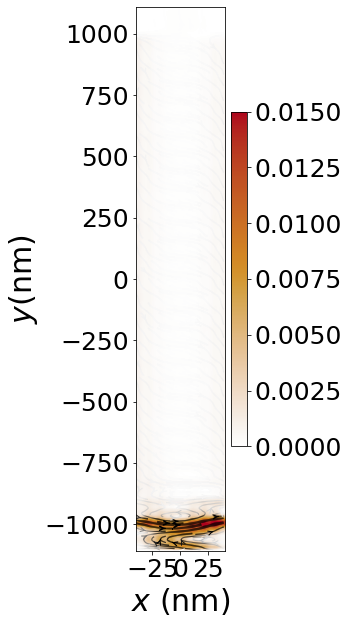

In [133]:
V_g1 = 0
V_g2 = 0
L_j = 80
W = 2000
W_q = 100
mu = 5*1e-3 
alpha = 50*1e-3
Delta = 0.2*1e-3
phi = 0.84*np.pi
B = 0.5
energy_values_f = -0.168937875751503*1e-3 
syst_open = make_system_open(L_j = L_j, W = W, W_q = W_q, bottom_leads = True, vertical_leads = True)
sysf_open = syst_open.finalized()

psi = kwant.wave_function(sysf_open, energy = energy_values_f,  params =dict( V_g1 = V_g1, V_g2 = V_g2,mu=mu, alpha = alpha, \
                                                             Delta = Delta, phi =phi, B = B))(1)
print( "Energy = ", energy_values_f*1e3 )

e_up_matrix = np.array([[1,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]])
h_do_matrix = np.array([[0,0,0,0],[0,1,0,0],[0,0,0,0],[0,0,0,0]])
e_do_matrix = np.array([[0,0,0,0],[0,0,0,0],[0,0,1,0],[0,0,0,0]])
h_up_matrix = np.array([[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,1]])

J_e_up = kwant.operator.Current(sysf_open, e_up_matrix).bind(params = dict(alpha=alpha))
J_h_do = kwant.operator.Current(sysf_open, h_do_matrix).bind(params = dict(alpha=alpha))
J_e_do = kwant.operator.Current(sysf_open, e_do_matrix).bind(params = dict(alpha=alpha))
J_h_up = kwant.operator.Current(sysf_open, h_up_matrix).bind(params = dict(alpha=alpha))

current_e_up = sum(J_e_up(p) for p in psi[:len(psi)//2])
current_h_do = sum(J_h_do(p) for p in psi[:len(psi)//2])
current_e_do = sum(J_e_do(p) for p in psi[:len(psi)//2])
current_h_up = sum(J_h_up(p) for p in psi[:len(psi)//2])

cbar = current_x_cut(sysf_open, current_e_up + current_e_do , x_min = -40, x_max = 40, vmax = 0.015,  fig_size = (2,10), relwidth = 0.008, colorbar = True);
plt.ylabel("$y$(nm)", fontsize = 30)
plt.xlabel("$x$ (nm)", fontsize = 30)
plt.tick_params(labelsize=25)
tick_font_size = 25
cbar.ax.tick_params(labelsize=tick_font_size)
plt.show()   

### $J_h$ for -ve energy

Energy =  -0.168937875751503


/root/miniconda3/envs/python3_new/lib/python3.9/site-packages/kwant/plotter.py:1694: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  coords -= pos_offsets[i]


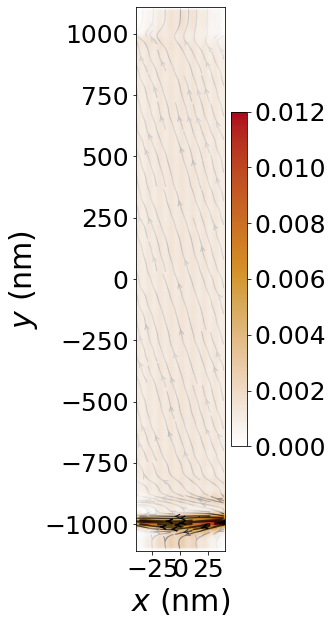

In [131]:
V_g1 = 0
V_g2 = 0
L_j = 80
W = 2000
W_q = 100
mu = 5*1e-3 
alpha = 50*1e-3
Delta = 0.2*1e-3
phi = 0.84*np.pi
B = 0.5
energy_values_f = -0.168937875751503*1e-3 

syst_open = make_system_open(L_j = L_j, W = W, W_q = W_q, bottom_leads = True, vertical_leads = True)
sysf_open = syst_open.finalized()

psi = kwant.wave_function(sysf_open, energy = energy_values_f,  params =dict( V_g1 = V_g1, V_g2 = V_g2,mu=mu, alpha = alpha, \
                                                             Delta = Delta, phi =phi, B = B))(1)
print("Energy = ", energy_values_f*1e3 )

e_up_matrix = np.array([[1,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]])
h_do_matrix = np.array([[0,0,0,0],[0,1,0,0],[0,0,0,0],[0,0,0,0]])
e_do_matrix = np.array([[0,0,0,0],[0,0,0,0],[0,0,1,0],[0,0,0,0]])
h_up_matrix = np.array([[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,1]])

J_e_up = kwant.operator.Current(sysf_open, e_up_matrix).bind(params = dict(alpha=alpha))
J_h_do = kwant.operator.Current(sysf_open, h_do_matrix).bind(params = dict(alpha=alpha))
J_e_do = kwant.operator.Current(sysf_open, e_do_matrix).bind(params = dict(alpha=alpha))
J_h_up = kwant.operator.Current(sysf_open, h_up_matrix).bind(params = dict(alpha=alpha))

current_e_up = sum(J_e_up(p) for p in psi[:len(psi)//2])
current_h_do = sum(J_h_do(p) for p in psi[:len(psi)//2])
current_e_do = sum(J_e_do(p) for p in psi[:len(psi)//2])
current_h_up = sum(J_h_up(p) for p in psi[:len(psi)//2])

cbar = current_x_cut(sysf_open, current_h_up + current_h_do , x_min = -40, x_max = 40, vmax = 0.012, fig_size = (2,10), relwidth = 0.008, colorbar = True);
plt.ylabel("$y$ (nm)", fontsize = 30)
plt.xlabel("$x$ (nm)", fontsize = 30)
plt.tick_params(labelsize=25)
tick_font_size = 25
cbar.ax.tick_params(labelsize=tick_font_size)
plt.show()   

## Figure 3(b)

### $J_e$ for +ve energy

Energy =  0.168937875751503


/root/miniconda3/envs/python3_new/lib/python3.9/site-packages/kwant/plotter.py:1694: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  coords -= pos_offsets[i]


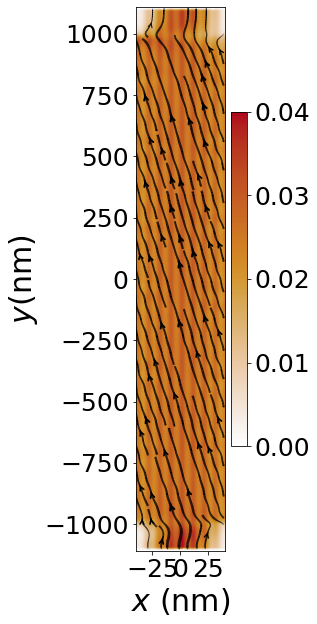

In [127]:
V_g1 = 0
V_g2 = 0
L_j = 80
W = 2000
W_q = 100
mu = 5*1e-3 
alpha = 50*1e-3
Delta = 0.2*1e-3
phi = 0.84*np.pi
B = 0.5
energy_values_f = 0.168937875751503*1e-3 

syst_open = make_system_open(L_j = L_j, W = W, W_q = W_q, bottom_leads = True, vertical_leads = True)
sysf_open = syst_open.finalized()

psi = kwant.wave_function(sysf_open, energy = energy_values_f,  params =dict( V_g1 = V_g1, V_g2 = V_g2,mu=mu, alpha = alpha, \
                                                             Delta = Delta, phi =phi, B = B))(1)
print( "Energy = ", energy_values_f*1e3 )

e_up_matrix = np.array([[1,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]])
h_do_matrix = np.array([[0,0,0,0],[0,1,0,0],[0,0,0,0],[0,0,0,0]])
e_do_matrix = np.array([[0,0,0,0],[0,0,0,0],[0,0,1,0],[0,0,0,0]])
h_up_matrix = np.array([[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,1]])

J_e_up = kwant.operator.Current(sysf_open, e_up_matrix).bind(params = dict(alpha=alpha))
J_h_do = kwant.operator.Current(sysf_open, h_do_matrix).bind(params = dict(alpha=alpha))
J_e_do = kwant.operator.Current(sysf_open, e_do_matrix).bind(params = dict(alpha=alpha))
J_h_up = kwant.operator.Current(sysf_open, h_up_matrix).bind(params = dict(alpha=alpha))

current_e_up = sum(J_e_up(p) for p in psi[:len(psi)//2])
current_h_do = sum(J_h_do(p) for p in psi[:len(psi)//2])
current_e_do = sum(J_e_do(p) for p in psi[:len(psi)//2])
current_h_up = sum(J_h_up(p) for p in psi[:len(psi)//2])

cbar = current_x_cut(sysf_open, current_e_up + current_e_do , x_min = -40, x_max = 40, vmax = 0.04,  fig_size = (2,10), relwidth = 0.008, colorbar = True);
plt.ylabel("$y$(nm)", fontsize = 30)
plt.xlabel("$x$ (nm)", fontsize = 30)
plt.tick_params(labelsize=25)
tick_font_size = 25
cbar.ax.tick_params(labelsize=tick_font_size)
plt.show()   

### $J_h$ for +ve energy

Energy =  0.168937875751503


/root/miniconda3/envs/python3_new/lib/python3.9/site-packages/kwant/plotter.py:1694: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  coords -= pos_offsets[i]


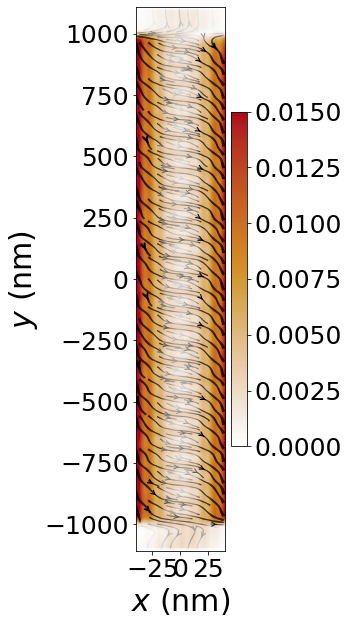

In [130]:
V_g1 = 0
V_g2 = 0
L_j = 80
W = 2000
W_q = 100
mu = 5*1e-3 
alpha = 50*1e-3
Delta = 0.2*1e-3
phi = 0.84*np.pi
B = 0.5
energy_values_f = 0.168937875751503*1e-3 

syst_open = make_system_open(L_j = L_j, W = W, W_q = W_q, bottom_leads = True, vertical_leads = True)
sysf_open = syst_open.finalized()

psi = kwant.wave_function(sysf_open, energy = energy_values_f,  params =dict( V_g1 = V_g1, V_g2 = V_g2,mu=mu, alpha = alpha, \
                                                             Delta = Delta, phi =phi, B = B))(1)
print("Energy = ", energy_values_f*1e3 )

e_up_matrix = np.array([[1,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]])
h_do_matrix = np.array([[0,0,0,0],[0,1,0,0],[0,0,0,0],[0,0,0,0]])
e_do_matrix = np.array([[0,0,0,0],[0,0,0,0],[0,0,1,0],[0,0,0,0]])
h_up_matrix = np.array([[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,1]])

J_e_up = kwant.operator.Current(sysf_open, e_up_matrix).bind(params = dict(alpha=alpha))
J_h_do = kwant.operator.Current(sysf_open, h_do_matrix).bind(params = dict(alpha=alpha))
J_e_do = kwant.operator.Current(sysf_open, e_do_matrix).bind(params = dict(alpha=alpha))
J_h_up = kwant.operator.Current(sysf_open, h_up_matrix).bind(params = dict(alpha=alpha))

current_e_up = sum(J_e_up(p) for p in psi[:len(psi)//2])
current_h_do = sum(J_h_do(p) for p in psi[:len(psi)//2])
current_e_do = sum(J_e_do(p) for p in psi[:len(psi)//2])
current_h_up = sum(J_h_up(p) for p in psi[:len(psi)//2])

cbar = current_x_cut(sysf_open, current_h_up + current_h_do , x_min = -40, x_max = 40, vmax =0.015, fig_size = (2,10), relwidth = 0.008, colorbar = True);
plt.ylabel("$y$ (nm)", fontsize = 30)
plt.xlabel("$x$ (nm)", fontsize = 30)
plt.tick_params(labelsize=25)
tick_font_size = 25
cbar.ax.tick_params(labelsize=tick_font_size)
plt.show()   

In [201]:
learner_t_B_05_nonlocal_Vg1_0_Vg2_0 = Learner2D(lambda value:calculate_nonlocal_conductance_map_top_an_diff_pot_height(phienergy = value, L_j = 80,\
                                                                                           W = 2000,W_q =100, V_g1 = 0,\
                                                                                           V_g2 = 0,mu = 5*1e-3,\
                                                                                           alpha = 50*1e-3,Delta = 0.2*1e-3,\
                                                                                           B = 0.5),bounds=[(-2*np.pi,2*np.pi), (-0.3, 0.3)])

runner_t_B_05_nonlocal_Vg1_0_Vg2_0 = adaptive.Runner(learner_t_B_05_nonlocal_Vg1_0_Vg2_0, executor=cluster, goal=lambda l: l.loss() < 0.002)
runner_t_B_05_nonlocal_Vg1_0_Vg2_0.live_info()

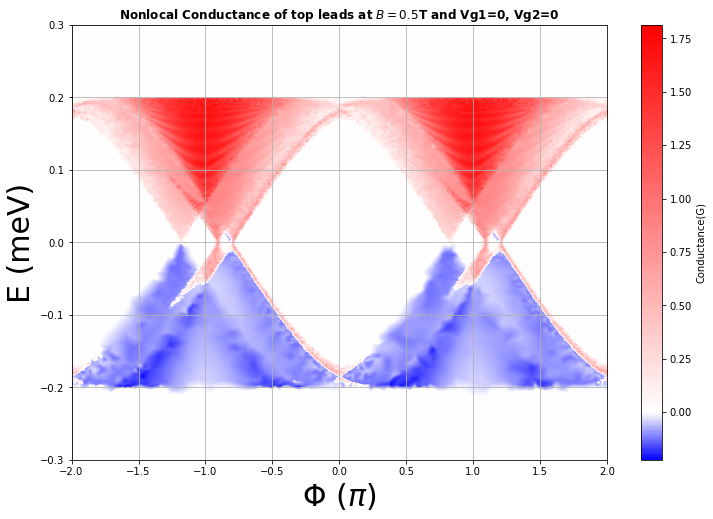

In [205]:
import matplotlib.colors as colors
G_map_t_B_05_nonlocal_Vg1_0_Vg2_0 = learner_t_B_05_nonlocal_Vg1_0_Vg2_0.plot().image.I.data
plt.figure(figsize=(12,8)) 
norm = colors.TwoSlopeNorm(vcenter=0)
plt.imshow(G_map_t_B_05_nonlocal_Vg1_0_Vg2_0, cmap="bwr",norm = norm, extent=[-2, 2, -0.3, 0.3], aspect='auto')
plt.colorbar(orientation = "vertical", label = "Conductance(G)")
plt.xlabel("$\Phi\\ (\pi)$", fontsize=30)
plt.ylabel("E (meV)", fontsize=30)
plt.title('Nonlocal Conductance of top leads at $B =0.5$T and Vg1=0, Vg2=0', fontweight ="bold");
plt.grid()

In [206]:
with open('G_map_t_B_05_nonlocal_Vg1_0_Vg2_0.pkl', 'wb') as Gmap_nonlocal_t_B_05_Vg1_0_Vg2_0:   
    pickle.dump(G_map_t_B_05_nonlocal_Vg1_0_Vg2_0, Gmap_nonlocal_t_B_05_Vg1_0_Vg2_0)

In [15]:
with open('G_map_t_B_05_nonlocal_Vg1_0_Vg2_0.pkl', 'rb') as Gmap_nonlocal_t_B_05_Vg1_0_Vg2_0:    
    G_map_t_B_05_Vg1_0_Vg2_0_pickle_nonlocal = pickle.load(Gmap_nonlocal_t_B_05_Vg1_0_Vg2_0)

In [16]:
slice_G = (G_map_t_B_05_Vg1_0_Vg2_0_pickle_nonlocal.shape)[0]
G_sli_redu = (slice_G - slice_G*0.2/0.3)/2

In [17]:
my_tuple = G_map_t_B_05_Vg1_0_Vg2_0_pickle_nonlocal.shape

new_tuple = tuple(item / 2 for item in my_tuple)

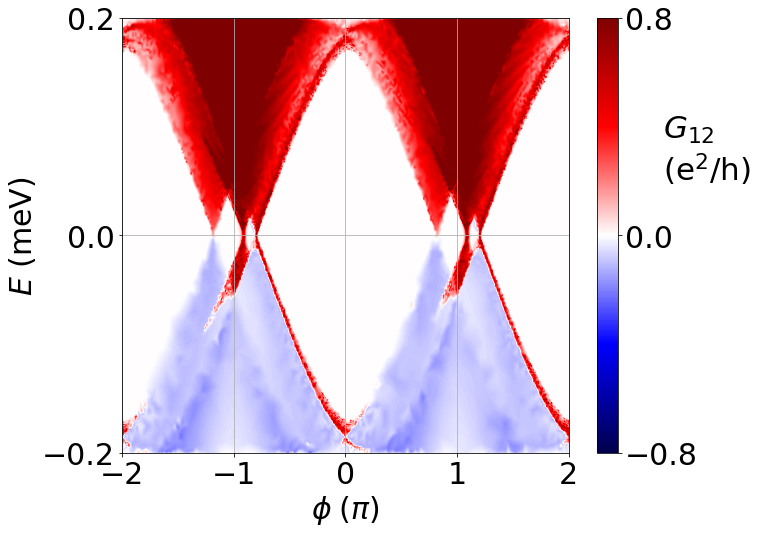

In [18]:
fig = plt.figure(figsize=(10,8))
norm = colors.TwoSlopeNorm(vcenter=0, vmax = 0.8, vmin = -0.8)
plt.imshow(G_map_t_B_05_Vg1_0_Vg2_0_pickle_nonlocal[int(G_sli_redu):int(slice_G-G_sli_redu),:],cmap="seismic", norm = norm, extent=[-2, 2, -0.2, 0.2], aspect='auto')
cbar = plt.colorbar(orientation = "vertical",  ticks=[-0.8, 0, 0.8])
plt.xlabel("$\phi\;(\pi)$", fontsize=30)
plt.ylabel("$E$ (meV)", fontsize=30)
plt.yticks([ -0.2, 0, 0.2]);
plt.xticks([ -2.0, -1.0, 0, 1.0, 2.0]);
plt.grid()
cbar.ax.tick_params(labelsize=30)
plt.text(2.85, 0.05, '$G_{\mathrm{12}}$ \n($\\rm e^2/h$)', fontsize=31)
plt.tick_params(labelsize=30)
plt.show()

# $T_{ee}$

In [19]:
%%px --local

def calculate_nonlocal_conductance_map_top_an_el(phienergy, L_j, W, W_q, V_g1, V_g2, mu, alpha, Delta, B):
    phi, energy = phienergy
    
    syst_open = make_system_open(L_j = L_j, W = W, W_q = W_q, bottom_leads = True, vertical_leads = True)
    sysf_open = syst_open.finalized()

    smatrix = kwant.smatrix(sysf_open, energy = energy*1e-3, params =dict( V_g1 = V_g1, V_g2 = V_g2,mu=mu, alpha = alpha, \
                                                                 Delta = Delta, B = B, phi =phi))
    
    return smatrix.transmission((1, 0), (0, 0))

# $T_{he}$

In [20]:
%%px --local

def calculate_nonlocal_conductance_map_top_an_hole(phienergy, L_j, W, W_q, V_g1, V_g2, mu, alpha, Delta, B):
    phi, energy = phienergy
    
    syst_open = make_system_open(L_j = L_j, W = W, W_q = W_q, bottom_leads = True, vertical_leads = True)
    sysf_open = syst_open.finalized()

    smatrix = kwant.smatrix(sysf_open, energy = energy*1e-3, params =dict( V_g1 = V_g1, V_g2 = V_g2,mu=mu, alpha = alpha, \
                                                                 Delta = Delta, B = B, phi =phi))
    
    return  smatrix.transmission((1, 1), (0, 0))

In [283]:
learner_t_B_1_nonlocal_Vg1_0_Vg2_0_el = Learner2D(lambda value:calculate_nonlocal_conductance_map_top_an_el(phienergy = value, L_j = 80,\
                                                                                           W = 2000,W_q =100, V_g1 = 0,\
                                                                                           V_g2 = 0,mu = 5*1e-3,\
                                                                                           alpha = 50*1e-3,Delta = 0.2*1e-3,\
                                                                                           B = 1),bounds=[(-2*np.pi,2*np.pi), (-0.3, 0.3)])

runner_t_B_1_nonlocal_Vg1_0_Vg2_0_el = adaptive.Runner(learner_t_B_1_nonlocal_Vg1_0_Vg2_0_el, executor=cluster, goal=lambda l: l.loss() < 0.001)
runner_t_B_1_nonlocal_Vg1_0_Vg2_0_el.live_info()

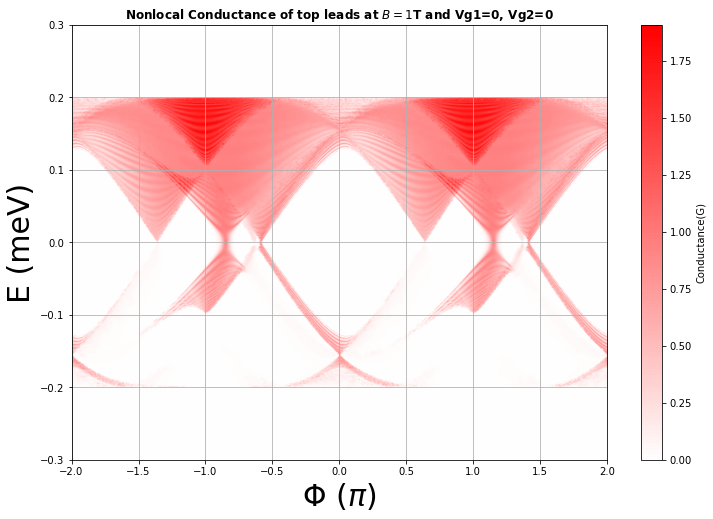

In [284]:
G_map_t_B_1_nonlocal_Vg1_0_Vg2_0_el = learner_t_B_1_nonlocal_Vg1_0_Vg2_0_el.plot().image.I.data
plt.figure(figsize=(12,8)) 
norm = colors.TwoSlopeNorm(vcenter=0)
plt.imshow(G_map_t_B_1_nonlocal_Vg1_0_Vg2_0_el, cmap="bwr",norm = norm, extent=[-2, 2, -0.3, 0.3], aspect='auto')
plt.colorbar(orientation = "vertical", label = "Conductance(G)")
plt.xlabel("$\Phi\\ (\pi)$", fontsize=30)
plt.ylabel("E (meV)", fontsize=30)
plt.title('Nonlocal Conductance of top leads at $B =1$T and Vg1=0, Vg2=0', fontweight ="bold");
plt.grid()

In [285]:
with open('G_map_t_B_1_nonlocal_Vg1_0_Vg2_0_el.pkl', 'wb') as Gmap_nonlocal_t_B_1_Vg1_0_Vg2_0_el:     # wt means: write tinary
    pickle.dump(G_map_t_B_1_nonlocal_Vg1_0_Vg2_0_el, Gmap_nonlocal_t_B_1_Vg1_0_Vg2_0_el)

In [21]:
with open('G_map_t_B_1_nonlocal_Vg1_0_Vg2_0_el.pkl', 'rb') as Gmap_nonlocal_t_B_1_Vg1_0_Vg2_0_el:    
    G_map_t_B_1_Vg1_0_Vg2_0_pickle_nonlocal = pickle.load(Gmap_nonlocal_t_B_1_Vg1_0_Vg2_0_el)

In [22]:
slice_G_1 = (G_map_t_B_1_Vg1_0_Vg2_0_pickle_nonlocal.shape)[0]
G_sli_redu_1 = (slice_G_1 - slice_G_1*0.2/0.3)/2

### Figure 4(c)

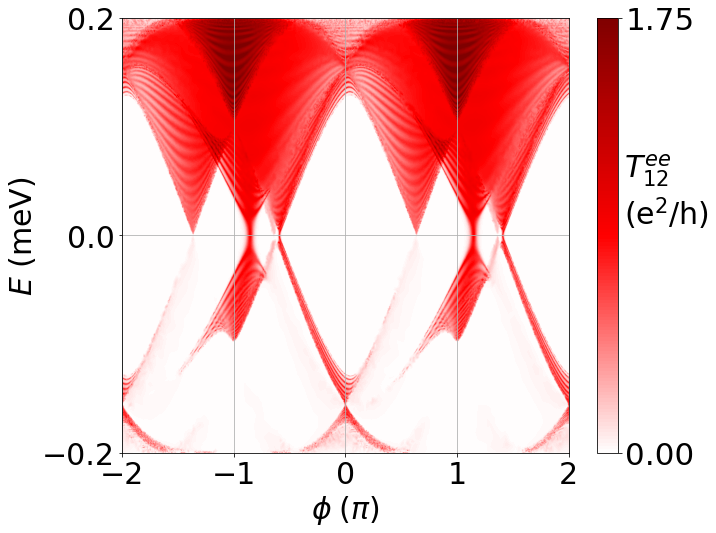

In [23]:
fig = plt.figure(figsize=(10,8))
norm = colors.TwoSlopeNorm(vcenter=0, vmax = 1.75)
plt.imshow(G_map_t_B_1_Vg1_0_Vg2_0_pickle_nonlocal[int(G_sli_redu_1):int(slice_G_1-G_sli_redu_1),:],cmap="seismic", norm = norm, extent=[-2, 2, -0.2, 0.2], aspect='auto')
cbar = plt.colorbar(orientation = "vertical", ticks=[0, 1.75])
plt.xlabel("$\phi\;(\pi)$", fontsize=30)
plt.ylabel("$E$ (meV)", fontsize=30)
plt.yticks([ -0.3, 0, 0.3]);
plt.xticks([ -2.0, -1.0, 0, 1.0, 2.0]);
plt.grid()
plt.ylim(0,0.2)
plt.yticks([-0.2, 0, 0.2]);
cbar.ax.tick_params(labelsize=31)
plt.text(2.5, 0.01, '$T^{ee}_{12}$ \n($\\rm e^2/h$)', fontsize=30)
plt.tick_params(labelsize=30)
plt.show()

# Adding disorder to the system

In [24]:
%%px --local

sigma_0 = np.identity(2)
sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.array([[1, 0], [0, -1]])
sigma_1 = np.array([[0, 1], [0, 0]])
sigma_2 = np.array([[0, 0], [1, 0]])
sigma_0sigma_z = np.array(np.kron(sigma_0,sigma_z))
sigma_ysigma_0 = np.array(np.kron(sigma_y,sigma_0))
sigma_xsigma_z = np.array(np.kron(sigma_x,sigma_z))
sigma_ysigma_z = np.array(np.kron(sigma_y,sigma_z))
sigma_0sigma_x = np.array(np.kron(sigma_0,sigma_x))
sigma_0sigma_1 = np.array(np.kron(sigma_0,sigma_1))
sigma_0sigma_2 = np.array(np.kron(sigma_0,sigma_2))

def make_system_open_with_disorder(L_j = 80, W = 2000, W_q = 100, bottom_leads = True, vertical_leads = True, salt1 = "1234" ):  
    a = 10e-9
    m = sc.m_e*0.014
    m2 = m*10
    t = (sc.hbar**2/(2*m*a**2))/sc.eV
    tm = (sc.hbar**2/(2*m2*a**2))/sc.eV
    g = -50
    miu_B = ((sc.e*sc.hbar)/(2*sc.m_e))/sc.eV
    
        
    def U_d(mu,l_e):
        lamda_F = (2*np.pi*sc.hbar)/np.sqrt(2*m*mu*sc.eV)  
        ret = mu*np.sqrt((6*lamda_F**3)/(np.pi**3*a**2*l_e*1e-9))
        return ret
    
    
    def barrier_potential_top(x, y, V_g1, L_j = L_j, W_q =W_q, y_position = (W/2 + W_q/5)):
        ret = 0
        if (W/2 < y < y_position  and -L_j/2 <= x <= L_j/2):
            ret = V_g1
    
        return ret
    
    def barrier_potential_bottom(x, y, V_g2, L_j = L_j, W_q =W_q, y_position_n = -(W/2 + W_q/5)):
        ret = 0
        if ( y_position_n < y < -W/2  and -L_j/2 <= x <= L_j/2):
            ret = V_g2

        return ret
    
    def onsite(site, V_g1, V_g2, B, mu, l_e):
        disorder = (lambda site, salt: (2 * uniform(repr(site), salt) - 1)/2)
        (x, y) = site.pos
        return (4*t - mu + barrier_potential_top(x, y, V_g1) + barrier_potential_bottom(x, y, V_g2) + \
                U_d(mu,l_e)*disorder(site, salt1))*sigma_0sigma_z + (g/2)*miu_B*B*sigma_ysigma_0   
    
    
    
    def hoppingx(site1, site2, alpha):
        (x1,y1 ) = site1.pos
        (x2,y2) = site2.pos
        return -t*sigma_0sigma_z - alpha*(1j/(2*a*1e9))*sigma_ysigma_z   
        
                
    def hoppingy(site1, site2, alpha):
        (x1,y1 ) = site1.pos
        (x2,y2) = site2.pos
        return -t*sigma_0sigma_z  + alpha*(1j/(2*a*1e9))*sigma_xsigma_z
    
 
    def onsite_left_SC_lead(site, Delta,mu):
        (x, y) = site.pos
        return (2*t + 2*tm - mu )*sigma_0sigma_z  + Delta*sigma_0sigma_x 
    
    def onsite_right_SC_lead(site, phi, Delta,mu):         
        (x, y) = site.pos
        return (2*t + 2*tm - mu )*sigma_0sigma_z  +  Delta*np.exp(1j*phi)*sigma_0sigma_1 + \
    Delta*np.exp(-1j*phi)*sigma_0sigma_2
    
    def onsite_normal_lead(site, mu, B):
        (x, y) = site.pos
        return (4*t - mu )*sigma_0sigma_z + (g/2)*miu_B*B*sigma_ysigma_0
    
    def wire_top(pos):
        (x, y) = pos
        return (-L_j /2 <= x <= L_j /2)
        
    def wire_bottom(pos):
        (x, y) = pos
        return (-L_j /2 <= x <= L_j /2 )
    
    
    def wire_left(pos):
        (x, y) = pos
        return (-W /2 <= y <= W /2)

        
    def wire_right(pos):
        (x, y) = pos
        return (-W /2 <= y <= W /2)
        
    def wire(pos):
        (x, y) = pos
        return (-L_j /2 <= x <= L_j /2  and -W/2 - W_q <= y <= W_q + W /2)

    lat = kwant.lattice.square(a*1e9, norbs = 4)
    syst = kwant.Builder()
    syst[lat.shape(wire, (0,0))] = onsite
    syst[kwant.builder.HoppingKind((1, 0), lat, lat)] = hoppingx
    syst[kwant.builder.HoppingKind((0, 1), lat, lat)] = hoppingy
    
     # left lead 
    sym_left = kwant.TranslationalSymmetry((-a*1e9, 0 ))
    lead0 = kwant.Builder(sym_left)
    lead0[lat.shape(wire_left, (0, 0))] = onsite_left_SC_lead
    lead0[kwant.builder.HoppingKind((1, 0), lat, lat)] = -t * sigma_0sigma_z
    lead0[kwant.builder.HoppingKind((0, 1), lat, lat)] = -tm * sigma_0sigma_z
    
    # Right lead 
    sym_right = kwant.TranslationalSymmetry((a*1e9, 0))
    lead1 = kwant.Builder(sym_right)
    lead1[lat.shape(wire_right, (0, 0))] = onsite_right_SC_lead
    lead1[kwant.builder.HoppingKind((1, 0), lat, lat)] = -t * sigma_0sigma_z
    lead1[kwant.builder.HoppingKind((0, 1), lat, lat)] = -tm *sigma_0sigma_z
    
# To constuct the Normal leads
    #To construct the top leads
    sym_top = kwant.TranslationalSymmetry((0, a*1e9 ))
    lead2 = kwant.Builder(sym_top, conservation_law=-sigma_0sigma_z)
    lead2[lat.shape(wire_top, (0, 0))] = onsite_normal_lead
    lead2[kwant.builder.HoppingKind((1, 0), lat, lat)] = hoppingx
    lead2[kwant.builder.HoppingKind((0, 1), lat, lat)] = hoppingy
    
    #To construct the bottom leads
    sym_below = kwant.TranslationalSymmetry((0, -a*1e9 ))
    lead3 = kwant.Builder(sym_below, conservation_law=-sigma_0sigma_z)
    lead3[lat.shape(wire_bottom, (0, 0))] = onsite_normal_lead 
    lead3[kwant.builder.HoppingKind((1, 0), lat, lat)] = hoppingx
    lead3[kwant.builder.HoppingKind((0, 1), lat, lat)] = hoppingy
    
    # attach the leads
    syst.attach_lead(lead2)
    
    if (bottom_leads == True):
        syst.attach_lead(lead3)
        
    if (vertical_leads == True):
        syst.attach_lead(lead0)
        syst.attach_lead(lead1)
    
    return syst        

In [25]:
syst_open_with_disorder = make_system_open_with_disorder(L_j = 80, W = 200, W_q = 100, bottom_leads = True,\
                                                         vertical_leads = True, salt1 = "")
sysf_open_with_disorder = syst_open_with_disorder.finalized()

/opt/conda/miniconda3/envs/python3/lib/python3.9/site-packages/kwant/plotter.py:144: ComplexWarning: Casting complex values to real discards the imaginary part
  color = np.asarray(color, dtype=float)


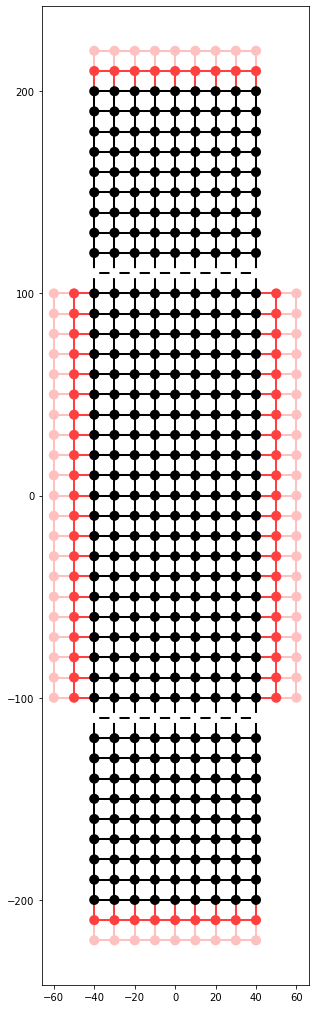

In [26]:
kwant.plotter.plot(sysf_open_with_disorder, fig_size = (18,18), colorbar = False,\
        site_color=lambda site: sysf_open_with_disorder.hamiltonian(site, site, params = dict(B = 2, alpha = 10*1e-3,\
                                                                                              V_g1 = 10, V_g2 = 10,\
                                                                                              mu=4*1e-3, Delta = 0.2*1e-3,\
                                                                                              phi = 0, l_e = 150))[0,0]);

## Nonlocal spectroscopy with disorder

### Nonlocal conductance  $E$ vs $\phi$

In [32]:
%%px --local

def calculate_nonlocal_conductance_map_top_an_diff_pot_height_with_disorder_empty_salt(phienergy, L_j, W, W_q, V_g1, V_g2, mu, alpha,\
                                                                         Delta, B, l_e):
    phi, energy = phienergy
    
    syst_open_with_disorder = make_system_open_with_disorder(L_j = L_j, W = W, W_q = W_q, bottom_leads = True,\
                                                             vertical_leads = True, salt1 = "")
    sysf_open_with_disorder = syst_open_with_disorder.finalized()

    smatrix = kwant.smatrix(sysf_open_with_disorder, energy = energy*1e-3, params =dict(V_g1 = V_g1, V_g2 = V_g2,mu=mu, alpha = alpha, \
                                                                 Delta = Delta, B = B, phi =phi, l_e = l_e))
    
    return smatrix.transmission((0, 0), (1, 0)) - smatrix.transmission((0, 1), (1, 0))

## Calculation of nonlocal conductance map w.r.t E and B with disorder

### For top lead

In [33]:
%%px --local

def nonlocal_conductance_E_vs_B_map_top_with_disorder_empty_salt(energy, L_j, W, W_q, V_g1, V_g2, mu, alpha,\
                                                                         Delta, phi, l_e, B): 
    
    syst_open_with_disorder = make_system_open_with_disorder(L_j = L_j, W = W, W_q = W_q, bottom_leads = True,\
                                                             vertical_leads = True, salt1 = "")
    sysf_open_with_disorder = syst_open_with_disorder.finalized()

    smatrix = kwant.smatrix(sysf_open_with_disorder, energy = energy*1e-3, params =dict( V_g1 = V_g1, V_g2 = V_g2,mu=mu, alpha = alpha, \
                                                                 Delta = Delta,  phi =phi, l_e = l_e, B = B))
    
    return smatrix.transmission((0, 0), (1, 0)) - smatrix.transmission((0, 1), (1, 0))


### For bottom lead

In [34]:
%%px --local

def nonlocal_conductance_E_vs_B_map_bottom_with_disorder_empty_salt(energy, L_j, W, W_q, V_g1, V_g2, mu, alpha,\
                                                                         Delta, phi, l_e, B):
    
    syst_open_with_disorder = make_system_open_with_disorder(L_j = L_j, W = W, W_q = W_q, bottom_leads = True,\
                                                             vertical_leads = True, salt1 = "")
    sysf_open_with_disorder = syst_open_with_disorder.finalized()

    smatrix = kwant.smatrix(sysf_open_with_disorder, energy = energy*1e-3, params =dict( V_g1 = V_g1, V_g2 = V_g2,mu=mu, alpha = alpha, \
                                                                 Delta = Delta,  phi =phi, l_e = l_e, B = B))
    
    return smatrix.transmission((1, 0), (0, 0)) - smatrix.transmission((1, 1), (0, 0))

### Non-local conductance calculation $E$ vs $\phi$ at $B = 0.5$T and $V_{g1} = 0.05 = V_{g2}$

In [51]:
def calculate_conductance_map_le_inf_with_equal_height_barriers_t_spect_B_05(phi_values, E_values):
    for phi in phi_values:
        def nonlocal_conductance_E_vs_B_map_top_with_disorder_empty_salt_HELPER(energy):
            L_j = 80
            W = 2000
            W_q = 100
            V_g1 = 0.05
            V_g2 = 0.05
            mu = 5*1e-3
            alpha = 50*1e-3
            Delta = 0.2*1e-3
            l_e = 1e18     
            B = 0.5
            return nonlocal_conductance_E_vs_B_map_top_with_disorder_empty_salt\
                (energy=energy, L_j=L_j, W=W, W_q=W_q, V_g1 =V_g1, V_g2=V_g2, mu =mu, alpha=alpha,\
                        Delta=Delta, phi=phi, l_e=l_e, B = B)
    
    
        res = lview.map_async(nonlocal_conductance_E_vs_B_map_top_with_disorder_empty_salt_HELPER ,E_values)
        nonlocal_conductance= res.get()
        G_B_05_le_inf_with_equal_height_barriers_t_spect.append(nonlocal_conductance)
    
    return G_B_05_le_inf_with_equal_height_barriers_t_spect

In [ ]:
G_B_05_le_inf_with_equal_height_barriers_t_spect = []
phi_values = np.linspace(-2*np.pi,2*np.pi, 200)
E_values=np.linspace(-0.2,0.2,200)

calculate_conductance_map_le_inf_with_equal_height_barriers_t_spect_B_05(phi_values, E_values)

In [54]:
with open('G_B_05_le_inf_with_equal_height_barriers_t_spect.pkl', 'wb') as P_G_B_05_le_inf_with_equal_height_barriers_t_spect:     
    pickle.dump(G_B_05_le_inf_with_equal_height_barriers_t_spect, P_G_B_05_le_inf_with_equal_height_barriers_t_spect)

In [35]:
with open('G_B_05_le_inf_with_equal_height_barriers_t_spect.pkl', 'rb') as P_G_B_05_le_inf_with_equal_height_barriers_t_spect:      
    Pickle_G_B_05_le_inf_with_equal_height_barriers_t_spect = pickle.load(P_G_B_05_le_inf_with_equal_height_barriers_t_spect)

### Figure 2(b)

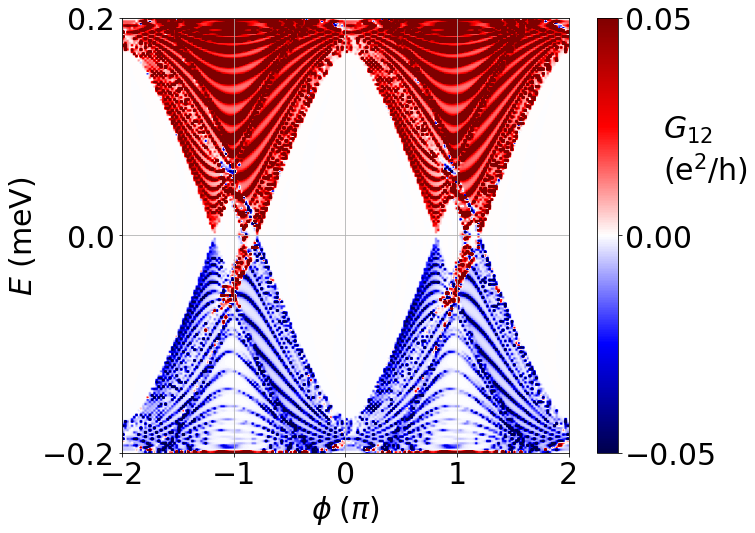

In [36]:
fig = plt.figure(figsize=(10,8))
norm = colors.TwoSlopeNorm(vcenter=0, vmax = 0.05, vmin = -0.05)
plt.imshow(np.array(Pickle_G_B_05_le_inf_with_equal_height_barriers_t_spect).T, cmap="seismic", norm = norm,origin = 'lower', extent=(-2, 2, -0.2, 0.2), aspect = "auto")
cbar = plt.colorbar(orientation = "vertical", ticks=[-0.05,0,0.05])
plt.xlabel("$\phi\;(\pi)$", fontsize=30)
plt.ylabel("$E$ (meV)", fontsize=30)
plt.yticks([ -0.2, 0, 0.2]);
plt.text(2.85, 0.05, '$G_{\mathrm{12}}$ \n($\\rm e^2/h$)', fontsize=30)
plt.tick_params(labelsize=30)
plt.grid()
plt.xlim(-2,2)
cbar.ax.tick_params(labelsize=30)
plt.show()

### With equal barrier height but without disorder

### $B = 0$

In [73]:
def calculate_conductance_map_le_inf_with_equal_height_barriers_t(phi_values, E_values):
    for phi in phi_values:
        def nonlocal_conductance_E_vs_B_map_top_with_disorder_empty_salt_HELPER(energy):
            L_j = 80
            W = 2000
            W_q = 100
            V_g1 = 0.05
            V_g2 = 0.05
            mu = 5*1e-3
            alpha = 50*1e-3
            Delta = 0.2*1e-3
            l_e = 1e18     
            B = 0
            return nonlocal_conductance_E_vs_B_map_top_with_disorder_empty_salt\
                (energy=energy, L_j=L_j, W=W, W_q=W_q, V_g1 =V_g1, V_g2=V_g2, mu =mu, alpha=alpha,\
                        Delta=Delta, phi=phi, l_e=l_e, B = B)
    
    
        res = lview.map_async(nonlocal_conductance_E_vs_B_map_top_with_disorder_empty_salt_HELPER ,E_values)
        nonlocal_conductance= res.get()
        G_B_0_le_inf_with_equal_height_barriers_t.append(nonlocal_conductance)
    
    return G_B_0_le_inf_with_equal_height_barriers_t

In [21]:
with open('phi_values_min_B_plane_0.pkl', 'rb') as phi_values_min_B_plane_0_pickle:    
     Pickle_phi_values_min_B_plane_0 = pickle.load(phi_values_min_B_plane_0_pickle)

In [ ]:
G_B_0_le_inf_with_equal_height_barriers_t = []
phi_values = np.array(Pickle_phi_values_min_B_plane_0)
E_values=np.linspace(-0.2,0.2,400)

calculate_conductance_map_le_inf_with_equal_height_barriers_t(phi_values, E_values)

In [77]:
with open('G_B_0_le_inf_with_equal_height_barriers_t.pkl', 'wb') as P_G_B_0_le_inf_with_equal_height_barriers_t:     
    pickle.dump(G_B_0_le_inf_with_equal_height_barriers_t, P_G_B_0_le_inf_with_equal_height_barriers_t)

In [37]:
with open('G_B_0_le_inf_with_equal_height_barriers_t.pkl', 'rb') as P_G_B_0_le_inf_with_equal_height_barriers_t:      
    Pickle_G_B_0_le_inf_with_equal_height_barriers_t = pickle.load(P_G_B_0_le_inf_with_equal_height_barriers_t)

### Figure 6(d)

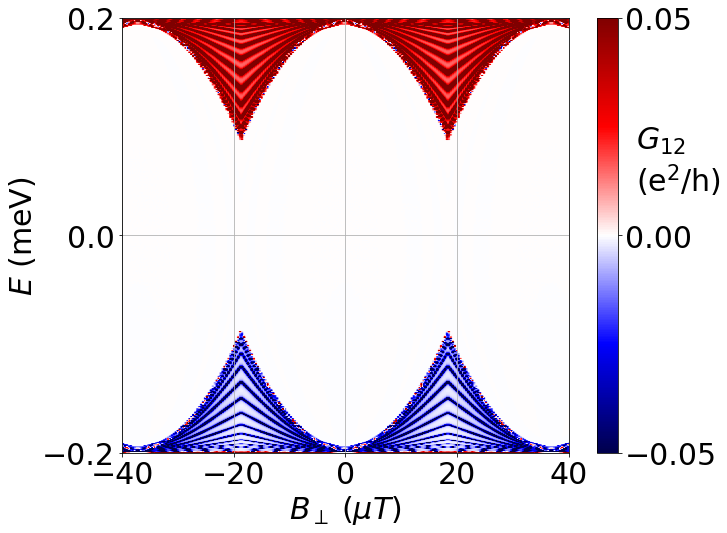

In [38]:
fig = plt.figure(figsize=(10,8))
norm = colors.TwoSlopeNorm(vcenter=0, vmax = 0.05, vmin = -0.05)
plt.imshow(np.array(Pickle_G_B_0_le_inf_with_equal_height_barriers_t).T, cmap="seismic", norm = norm,origin = 'lower', extent=(-70, 70, -0.2, 0.2), aspect = "auto")
cbar = plt.colorbar(orientation = "vertical", ticks=[-0.05,0,0.05])
plt.xlabel("$B_{\perp}\;(\mu T)$", fontsize=30)
plt.ylabel("$E$ (meV)", fontsize=30)
plt.yticks([ -0.2, 0, 0.2]);
plt.text(52.0, 0.04, '$G_{\mathrm{12}}$ \n($\\rm e^2/h$)', fontsize=30)
plt.tick_params(labelsize=30)
plt.grid()
plt.xlim(-40,40)
cbar.ax.tick_params(labelsize=30)
plt.show()

### $B = 0.5$T

In [213]:
def calculate_conductance_map_le_inf_with_equal_height_barriers_t_B_05(phi_values, E_values):
    for iphi, phi in enumerate(phi_values):
        print(iphi, phi)
        def nonlocal_conductance_E_vs_B_map_top_with_disorder_empty_salt_HELPER(energy):
            L_j = 80
            W = 2000
            W_q = 100
            V_g1 = 0.05
            V_g2 = 0.05
            mu = 5*1e-3
            alpha = 50*1e-3
            Delta = 0.2*1e-3
            l_e = 1e18     
            B = 0.5
            return nonlocal_conductance_E_vs_B_map_top_with_disorder_empty_salt\
                (energy=energy, L_j=L_j, W=W, W_q=W_q, V_g1 =V_g1, V_g2=V_g2, mu =mu, alpha=alpha,\
                        Delta=Delta, phi=phi, l_e=l_e, B = B)
    
        if (iphi == 1) or iphi ==366: 
            G_B_05_le_inf_with_equal_height_barriers_t.append(np.zeros(len(E_values))) 
        else:
            res = lview.map_async(nonlocal_conductance_E_vs_B_map_top_with_disorder_empty_salt_HELPER ,E_values)
            nonlocal_conductance= res.get()
            G_B_05_le_inf_with_equal_height_barriers_t.append(nonlocal_conductance)  
        
    return G_B_05_le_inf_with_equal_height_barriers_t

In [39]:
with open('phi_values_min_B_plane_05.pkl', 'rb') as phi_values_min_B_plane_05_pickle:    
     Pickle_phi_values_min_B_plane_05 = pickle.load(phi_values_min_B_plane_05_pickle)

In [ ]:
G_B_05_le_inf_with_equal_height_barriers_t = []
phi_values = np.array(Pickle_phi_values_min_B_plane_05)
E_values=np.linspace(-0.2,0.2,400)

calculate_conductance_map_le_inf_with_equal_height_barriers_t_B_05(phi_values, E_values)

In [217]:
with open('G_B_05_le_inf_with_equal_height_barriers_t.pkl', 'wb') as P_G_B_05_le_inf_with_equal_height_barriers_t:     
    pickle.dump(G_B_05_le_inf_with_equal_height_barriers_t, P_G_B_05_le_inf_with_equal_height_barriers_t)

In [40]:
with open('G_B_05_le_inf_with_equal_height_barriers_t.pkl', 'rb') as P_G_B_05_le_inf_with_equal_height_barriers_t:      
    Pickle_G_B_05_le_inf_with_equal_height_barriers_t = pickle.load(P_G_B_05_le_inf_with_equal_height_barriers_t)

### Figure 6(e)

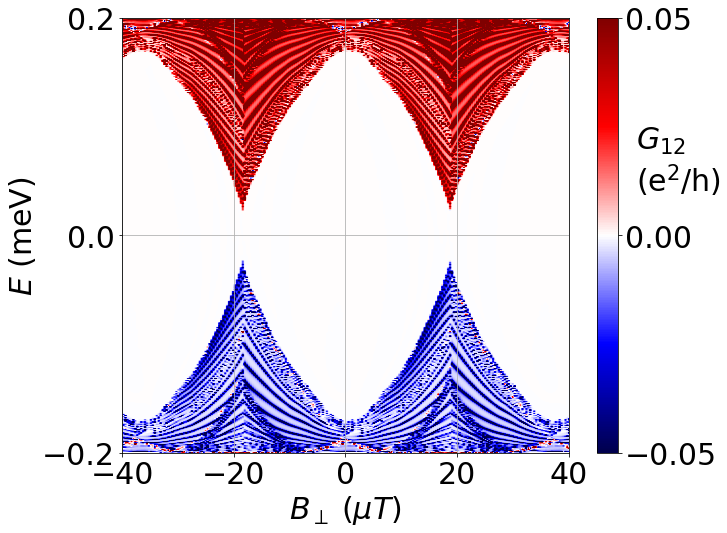

In [41]:
fig = plt.figure(figsize=(10,8))
norm = colors.TwoSlopeNorm(vcenter=0, vmax = 0.05, vmin = -0.05)
plt.imshow(np.array(Pickle_G_B_05_le_inf_with_equal_height_barriers_t).T, cmap="seismic", norm = norm,origin = 'lower', extent=(-70, 70, -0.2, 0.2), aspect = "auto")
cbar = plt.colorbar(orientation = "vertical", ticks=[-0.05,0,0.05])
plt.xlabel("$B_{\perp}\;(\mu T)$", fontsize=30)
plt.ylabel("$E$ (meV)", fontsize=30)
plt.yticks([ -0.2, 0, 0.2]);
plt.text(52.0, 0.04, '$G_{\mathrm{12}}$ \n($\\rm e^2/h$)', fontsize=30)
plt.tick_params(labelsize=30)
plt.grid()
cbar.ax.tick_params(labelsize=30)
plt.xlim(-40,40)
plt.show()

### $B = 1$T

In [224]:
def calculate_conductance_map_le_inf_with_equal_height_barriers_t_B_1(phi_values, E_values):
    for iphi, phi in enumerate(phi_values):
        print(iphi, phi)
        def nonlocal_conductance_E_vs_B_map_top_with_disorder_empty_salt_HELPER(energy):
            L_j = 80
            W = 2000
            W_q = 100
            V_g1 = 0.05
            V_g2 = 0.05
            mu = 5*1e-3
            alpha = 50*1e-3
            Delta = 0.2*1e-3
            l_e = 1e18     
            B = 1
            return nonlocal_conductance_E_vs_B_map_top_with_disorder_empty_salt\
                (energy=energy, L_j=L_j, W=W, W_q=W_q, V_g1 =V_g1, V_g2=V_g2, mu =mu, alpha=alpha,\
                        Delta=Delta, phi=phi, l_e=l_e, B = B)
    
    
        if (iphi == 1) or iphi ==366: 
            G_B_1_le_inf_with_equal_height_barriers_t.append(np.zeros(len(E_values))) 
        else:
            res = lview.map_async(nonlocal_conductance_E_vs_B_map_top_with_disorder_empty_salt_HELPER ,E_values)
            nonlocal_conductance= res.get()
            G_B_1_le_inf_with_equal_height_barriers_t.append(nonlocal_conductance)  
        
    return G_B_1_le_inf_with_equal_height_barriers_t

In [42]:
with open('phi_values_min_B_plane_1.pkl', 'rb') as phi_values_min_B_plane_1_pickle:    
     Pickle_phi_values_min_B_plane_1 = pickle.load(phi_values_min_B_plane_1_pickle)

In [ ]:
G_B_1_le_inf_with_equal_height_barriers_t = []
phi_values = np.array(Pickle_phi_values_min_B_plane_1)
E_values=np.linspace(-0.2,0.2,400)

calculate_conductance_map_le_inf_with_equal_height_barriers_t_B_1(phi_values, E_values)

In [228]:
with open('G_B_1_le_inf_with_equal_height_barriers_t.pkl', 'wb') as P_G_B_1_le_inf_with_equal_height_barriers_t:     
    pickle.dump(G_B_1_le_inf_with_equal_height_barriers_t, P_G_B_1_le_inf_with_equal_height_barriers_t)

In [43]:
with open('G_B_1_le_inf_with_equal_height_barriers_t.pkl', 'rb') as P_G_B_1_le_inf_with_equal_height_barriers_t:      
    Pickle_G_B_1_le_inf_with_equal_height_barriers_t = pickle.load(P_G_B_1_le_inf_with_equal_height_barriers_t)

### Figure 6(f)

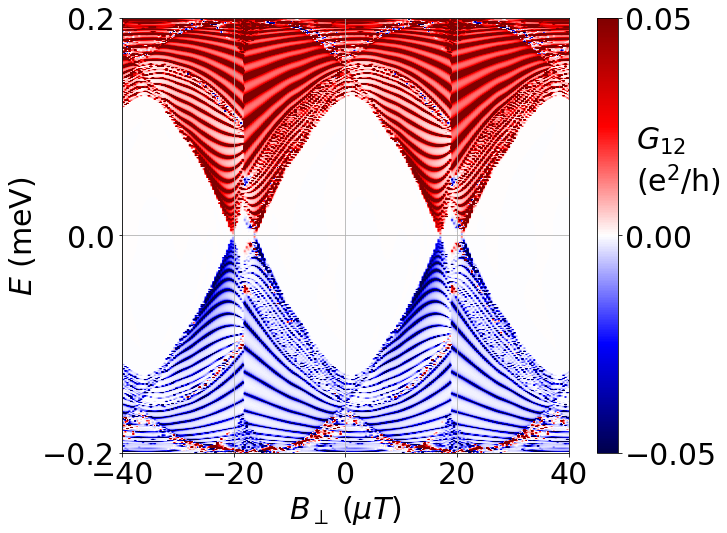

In [44]:
fig = plt.figure(figsize=(10,8))
norm = colors.TwoSlopeNorm(vcenter=0, vmax = 0.05, vmin = -0.05)
plt.imshow(np.array(Pickle_G_B_1_le_inf_with_equal_height_barriers_t).T, cmap="seismic", norm = norm,origin = 'lower', extent=(-70, 70, -0.2, 0.2), aspect = "auto")
cbar = plt.colorbar(orientation = "vertical",ticks=[-0.05,0,0.05])
plt.xlabel("$B_{\perp}\;(\mu T)$", fontsize=30)
plt.ylabel("$E$ (meV)", fontsize=30)
plt.yticks([ -0.2, 0, 0.2]);
plt.text(52.0, 0.04, '$G_{\mathrm{12}}$ \n($\\rm e^2/h$)', fontsize=30)
plt.tick_params(labelsize=30)
plt.grid()
cbar.ax.tick_params(labelsize=30)
plt.xlim(-40,40)
plt.show()

### Analytical flux to phase coonversion

# $E(\phi) = \Delta \sqrt{1- \tau \sin^2\left(\frac{\phi +\phi_\sigma}{2}\right)}$ where
### $\phi_\sigma = \frac{2\sigma E_{z}L}{\hbar v_{\sigma}}$, $\tau$ is the junction transmission coefficient
### $E_z = g\mu_{B}B/2$ and $v_{\sigma} = \sqrt{\frac{2\mu}{m}}$

In [45]:
def En_analytical_spin(phi, B_plane, miu, Delta, T, spin, N):
    L = 80
    g = -50
    m = sc.m_e*0.014 
    def E_z(B_plane):
        miu_B_plane = (sc.e*sc.hbar)/(2*sc.m_e)
        return (g*miu_B_plane*B_plane)/2
    
    def Fermi_velo_term(miu):
        factor = sc.hbar*np.sqrt(2/m)
        return factor*np.sqrt(miu*sc.eV)
    
    phase_shift_spin = (phi/2) + spin*((E_z(B_plane)*L*1e-9)/Fermi_velo_term(miu))                                        
    return N*Delta*np.sqrt(1-T*np.sin(phase_shift_spin)**2)

In [46]:
def energy_sum_ana_N(phi, B_plane, miu, Delta, T, N):
    E_Total = En_analytical_spin(phi = phi, B_plane = B_plane, miu = miu, Delta = Delta, T = T, spin = 1, N = N) + \
    En_analytical_spin(phi = phi, B_plane = B_plane, miu = miu, Delta = Delta, T = T, spin = -1, N = N)
    return E_Total*sc.eV

## Calculation of supercurrent analytically
## $I(\phi) = \frac{e \Delta^2 \tau M}{4\hbar}\sum_{\sigma = \pm 1}\frac{\sin(\phi + \phi_\sigma)}{E(\phi)}$

In [47]:
def current_vs_phase_ana_N(phi, B_plane, miu, Delta, T, N):
    def current_for_spin_N(phi, B_plane, miu, Delta, T, spin, N):
        L = 80
        g = -50
        m = sc.m_e*0.014

        def E_z(B_plane):
            miu_B_plane = (sc.e*sc.hbar)/(2*sc.m_e)
            return (g*miu_B_plane*B_plane)/2

        def Fermi_velo_term(miu):
            factor = sc.hbar*np.sqrt(2/m)
            return factor*np.sqrt(miu*sc.eV)

        phase_shift_spin = (phi) + 2*spin*((E_z(B_plane)*L*1e-9)/Fermi_velo_term(miu))
        I = np.sin(phase_shift_spin)*T
        I /= np.sqrt(1 - T*np.sin(phase_shift_spin/2)**2)

        return sc.e*(Delta*sc.eV)/4/sc.hbar*I*N

    
    
    current = (current_for_spin_N(phi = phi, B_plane = B_plane, miu = miu, Delta = Delta, T = T, spin = 1, N = N)\
                     + current_for_spin_N(phi = phi, B_plane = B_plane, miu = miu, Delta = Delta, T = T, spin = -1, N = N))

    
    return current


In [48]:
def fluxphase_ana_N(phi, flux, beta, B_plane, miu, Delta, T, N):
    return beta*current_vs_phase_ana_N(phi = phi, B_plane = B_plane, miu = miu, Delta = Delta, T = T, N =N)+ phi - 2*np.pi*flux

In [26]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

black_patch = mpatches.Patch(color='k', label='B = 0')
red_patch = mpatches.Patch(color='r', label='B = 1 T')

In [29]:
def calculate_flux_to_phase_ana_N_for_B_plane_0_and_1(B_values, B_plane, L = 321*1e-12, R = 4207*1e-9, miu = 5*1e-3, Delta = 0.2*1e-3, T = 0.99,\
                                N = 30):
    plt.figure(figsize=(8,6))
    colors = ['k', 'r']
    for i, B_plane in enumerate(B_plane_values):
        
        flux_quanta = (sc.hbar*np.pi)/sc.e

        beta = (2*np.pi*L)/flux_quanta

        flux = (B_values*np.pi*R*R)/flux_quanta

        all_phases = [] 

        for iB, B in enumerate(B_values):
            roots = []
            for x0 in np.linspace(-100, 100, 100):
                y = scipy.optimize.root(fluxphase_ana_N, x0, args = (flux[iB], beta, B_plane, miu, Delta, T, N))
                if y.success and (round(y.x[0], 8) not in roots):
                    roots.append(round(y.x[0], 8))
            all_phases.append(np.resize(roots, 3))

        phases_energy_minimalization = []


        for iB, B in enumerate(B_values):
            roots = []

            for x0 in np.linspace(-100,100,100):
                y = scipy.optimize.root(fluxphase_ana_N, x0, args = (flux[iB], beta, B_plane, miu, Delta, T, N))
                if y.success and (round(y.x[0], 7) not in roots):
                    roots.append(round(y.x[0], 7))

            energies = []
            for phase in roots:
                energy = -energy_sum_ana_N(phi = phase, B_plane = B_plane, miu = miu, Delta = Delta, T = T, N = N)
                energy += 0.5*L*current_vs_phase_ana_N(phi = phase, B_plane = B_plane , miu = miu, Delta = Delta, T = T, N = N)**2
                energies.append(energy)
                min_index = np.argmin(energies)
            phases_energy_minimalization.append(roots[min_index])

        plt.plot(B_values*1e6, np.array(all_phases)/np.pi, "o", color = colors[i])
        plt.plot(B_values*1e6, np.array(phases_energy_minimalization)/np.pi, "-", color = colors[i])
    plt.legend(handles=[black_patch, red_patch], fontsize = 20)    
    plt.ylabel("$\phi\;(\pi)$", fontsize = 30)
    plt.xlabel("$B_{\perp}\;(\mu$T$)$", fontsize = 30)
    plt.xlim(-40,40)
    plt.ylim(-2, 2)
    plt.yticks([-2, -1, 0, 1, 2])
    plt.tick_params(labelsize=30)
    plt.grid()
    plt.show()

In [30]:
B_values = np.linspace(-70,70,600)*1e-6
B_plane_values = np.array([0, 1])

## Figure 5(a)

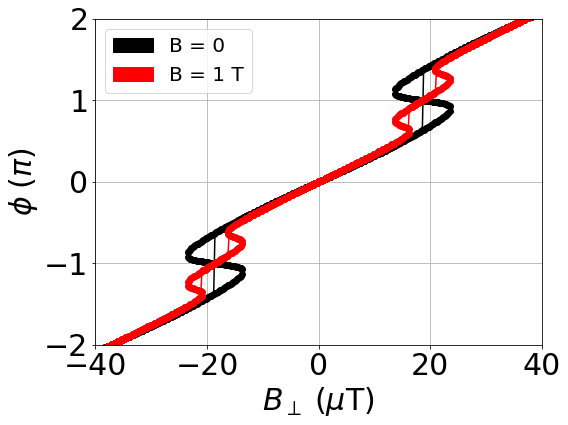

In [31]:
calculate_flux_to_phase_ana_N_for_B_plane_0_and_1(B_values, B_plane = B_plane_values, L = 321*1e-12, R = 4207*1e-9, miu = 5*1e-3, Delta = 0.2*1e-3,\
                            T = 0.99,N = 30)

## Here we extract the $\Phi_{m}$ for the corresponding $B_{\perp}$ values

In [40]:
def calculate_flux_to_phase_ana_N_for_B_plane_values(B_values, L, R, B_plane, miu, Delta, T, N):
   
    flux_quanta = (sc.hbar*np.pi)/sc.e
    
    beta = (2*np.pi*L)/flux_quanta
    
    flux = (B_values*np.pi*R*R)/flux_quanta
    
    all_phases = [] 
    
    for iB, B in enumerate(B_values):
        roots = []
        for x0 in np.linspace(-100, 100, 100):
            y = scipy.optimize.root(fluxphase_ana_N, x0, args = (flux[iB], beta, B_plane, miu, Delta, T, N))
            if y.success and (round(y.x[0], 8) not in roots):
                roots.append(round(y.x[0], 8))
        all_phases.append(np.resize(roots, 3))
        
    phases_energy_minimalization = []


    for iB, B in enumerate(B_values):
        roots = []

        for x0 in np.linspace(-100,100,100):
            y = scipy.optimize.root(fluxphase_ana_N, x0, args = (flux[iB], beta, B_plane, miu, Delta, T,N))
            if y.success and (round(y.x[0], 7) not in roots):
                roots.append(round(y.x[0], 7))

        energies = []
        for phase in roots:
            energy = -energy_sum_ana_N(phi = phase, B_plane = B_plane, miu = miu, Delta = Delta, T = T, N = N)
            energy += 0.5*L*current_vs_phase_ana_N(phi = phase, B_plane = B_plane, miu = miu, Delta = Delta, T = T, N = N)**2
            energies.append(energy)
            min_index = np.argmin(energies) 
        phases_energy_minimalization.append(roots[min_index])
    
    return (phases_energy_minimalization)

In [41]:
B_values = np.linspace(-70,70,400)*1e-6
B_plane_values = np.linspace(0, 2, 40) 
phi_min_values_for_B_plane_values = []
for B_phase in B_plane_values:
    phi_min_values_for_B_plane_values.append(calculate_flux_to_phase_ana_N_for_B_plane_values(B_values, L = 321*1e-12, R = 4207*1e-9, \
                                                                               B_plane = B_phase,miu = 5*1e-3, \
                                                                               Delta = 0.2*1e-3, T = 0.99, N = 30))

In [43]:
with open('phi_min_values_for_B_plane_values.pkl', 'wb') as phi_min_values_for_B_plane_values_pickle:     
    pickle.dump(phi_min_values_for_B_plane_values, phi_min_values_for_B_plane_values_pickle)

In [49]:
with open('phi_min_values_for_B_plane_values.pkl', 'rb') as phi_min_values_for_B_plane_values_pickle:    
     Pickle_phi_min_values_for_B_plane_values = pickle.load(phi_min_values_for_B_plane_values_pickle)

In [51]:
B_values = np.linspace(-70,70,400)*1e-6
B_plane_values = np.linspace(0, 2, 40) 

In [52]:
new_phi_min_values_for_B_plane_values = []

for iall_phases_for_a_given_B, all_phases_for_a_given_B in enumerate(Pickle_phi_min_values_for_B_plane_values):
    for phase_for_a_given_B in all_phases_for_a_given_B:
        new_phi_min_values_for_B_plane_values.append([B_plane_values[iall_phases_for_a_given_B], phase_for_a_given_B])
        
new_phi_min_values_for_B_plane_values = np.array(new_phi_min_values_for_B_plane_values)

## To evaluate the $\Phi$ values for which we are getting $E = 0$

### The positive and the negative roots of $E$ = 0  are 
### $\phi_{sol}^p = -aB_{plane} + \pi(1+2n)$
### $\phi_{sol}^n = aB_{plane} + \pi(1-2n)$ 
Where $n \in Z$

# $a = \frac{2g\mu_{B}L/2}{\hbar v_{\sigma}}$

In [53]:
 def constant_a():
    L = 80
    g = -50
    m = sc.m_e*0.014
    def E_z_term():
        miu_B_plane = (sc.e*sc.hbar)/(2*sc.m_e)
        return ((g*miu_B_plane)/2)*2*L*1e-9

    def Fermi_velo_term():
        miu = 5*1e-3
        factor = sc.hbar*np.sqrt(2/m)
        return factor*np.sqrt(miu*sc.eV)
    return E_z_term()/Fermi_velo_term()

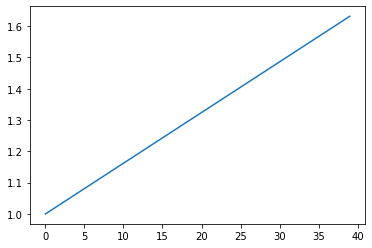

In [62]:
n = 0

phi_pos_1 = -constant_a()*B_plane_values + np.pi*(1+2*n) 

plt.plot(phi_pos_1/np.pi)
plt.show()

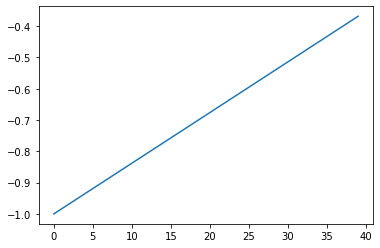

In [63]:
n = -1

phi_pos_2 = -constant_a()*B_plane_values + np.pi*(1+2*n) 

plt.plot(phi_pos_2/np.pi)
plt.show()

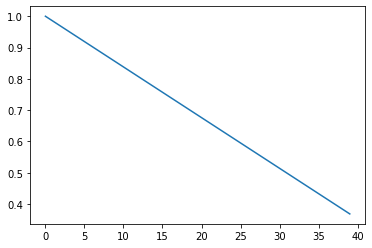

In [64]:
n = 0

phi_neg_1 =  constant_a()*B_plane_values + np.pi*(1-2*n)

plt.plot(phi_neg_1/np.pi)
plt.show()

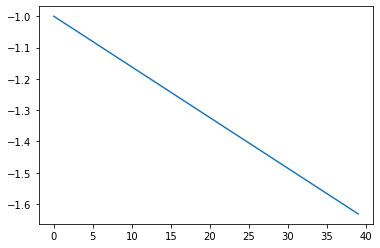

In [65]:
n = 1

phi_neg_2 =  constant_a()*B_plane_values + np.pi*(1-2*n)

plt.plot(phi_neg_2/np.pi)
plt.show()

## Figure 5(b)

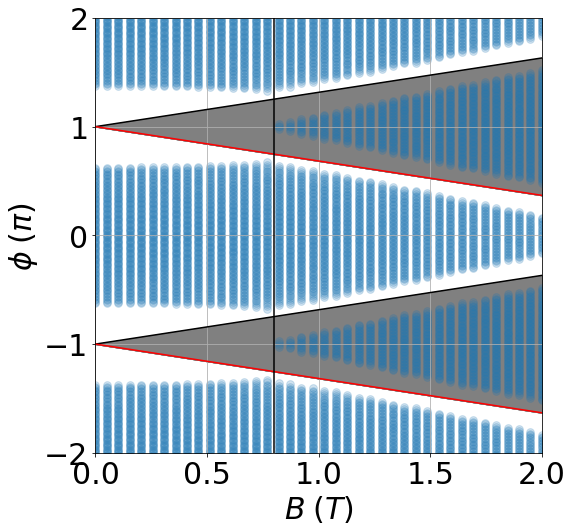

In [66]:
B_plane_values = np.linspace(0, 2, 40)
plt.figure(figsize=(8,8))
for n in range(-3, 3):
    phi_pos = -constant_a()*B_plane_values + np.pi*(1+2*n) 
    phi_neg =  constant_a()*B_plane_values + np.pi*(1-2*n)
    plt.plot(B_plane_values, np.array(phi_pos)/np.pi, "k-")
    plt.plot(B_plane_values, np.array(phi_neg)/np.pi, "r-")
    plt.fill_between(B_plane_values, phi_neg_1/np.pi ,phi_pos_1/np.pi, color = "gray")
    plt.fill_between(B_plane_values, phi_neg_2/np.pi ,phi_pos_2/np.pi, color = "gray")
plt.scatter(new_phi_min_values_for_B_plane_values[:,0], new_phi_min_values_for_B_plane_values[:,1]/np.pi, s=60, marker = "o", alpha = 0.2)
plt.xlabel("$B\;(T)$", fontsize = 30)
plt.ylabel("$\phi\;(\pi)$", fontsize = 30)
plt.tick_params(labelsize=30)
plt.xlim(0.0, 2.0)
plt.yticks([-2, -1, 0, 1, 2])
plt.ylim(-2.0, 2.0)
plt.grid()
plt.axvline(x = 0.8, c= "k")
plt.show()

## To make a map where this condition satisfy 
$\varphi_z + \frac{2\pi}{\Phi_0}LI_+(\pi + 2\varphi_z) < 0$

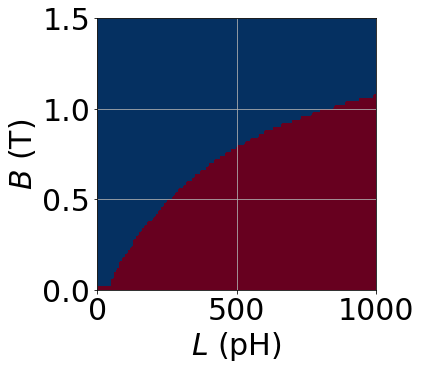

In [61]:
def phase_z(B_plane,miu, Delta):
    L_N = 80
    g = -50
    m = sc.m_e*0.014

    def E_z(B_plane):
        miu_B_plane = (sc.e*sc.hbar)/(2*sc.m_e)
        return (g*miu_B_plane*B_plane)/2

    def Fermi_velo_term(miu):
        factor = sc.hbar*np.sqrt(2/m)
        return factor*np.sqrt(miu*sc.eV)

    phase_z = 2*((E_z(B_plane)*L_N*1e-9)/Fermi_velo_term(miu))
    
    return phase_z

def current_vs_phi_z_phase_ana_new_N(B_plane, L, miu, Delta, T, N):
    flux_quanta = (sc.hbar*np.pi)/sc.e
    beta = (2*np.pi*L*1e-12)/flux_quanta
    
    def current_for_spin_N(B_plane, miu, Delta, T, spin, N):
        phase_shift_spin = 2*phase_z(B_plane = B_plane,  miu = miu, Delta = Delta) + np.pi
        I = np.sin(phase_shift_spin)*T
        I /= np.sqrt(1 - T*np.sin(phase_shift_spin/2)**2)

        return sc.e*(Delta*sc.eV)/4/sc.hbar*I*N    
    current = current_for_spin_N(B_plane = B_plane,  miu = miu, Delta = Delta, T = T, spin = 1, N = N)
    
    return current*beta

miu = 5*1e-3
Delta = 0.2*1e-3
T = 0.99
N = 30
B_plane_vals = np.linspace(0, 2, 100)
L_vals = np.linspace(0, 1000, 100)

B_plane_grid, L_grid = np.meshgrid(B_plane_vals, L_vals)


condition_grid = (phase_z(B_plane_grid, miu, Delta) + current_vs_phi_z_phase_ana_new_N(B_plane_grid, L_grid, miu, Delta, T,N)) < 0

cmap = plt.cm.get_cmap('RdBu', 2)
plt.figure(figsize = (5,5))
plt.imshow(condition_grid.T, extent=[np.min(L_vals), np.max(L_vals), np.min(B_plane_vals), np.max(B_plane_vals)],\
           cmap=cmap,origin = "lower", aspect='auto')          
plt.ylabel('$B$ (T)', fontsize=30)
plt.xlabel('$L$ (pH)', fontsize=30)
plt.tick_params(labelsize=30)
plt.grid() 
plt.ylim(0, 1.5)
plt.yticks([0, 0.5, 1.0, 1.5])
plt.show()
